Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,Activation, BatchNormalization
from keras.optimizers import SGD
from tensorflow.keras.models import Sequential

In [32]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [42]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/melanoma_detection_assignment/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/melanoma_detection_assignment/Test")

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size = batch_size,
    image_size = (img_height, img_width),
    seed = 123,
    validation_split= 0.2,
    subset = 'training'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size = batch_size,
    image_size = (img_height, img_width),
    seed = 123,
    validation_split= 0.2,
    subset = 'validation'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
#for img, lbl in val_ds.take(1):
#  for i in range(1):
#    im = img[i]
#    print(i)

0


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

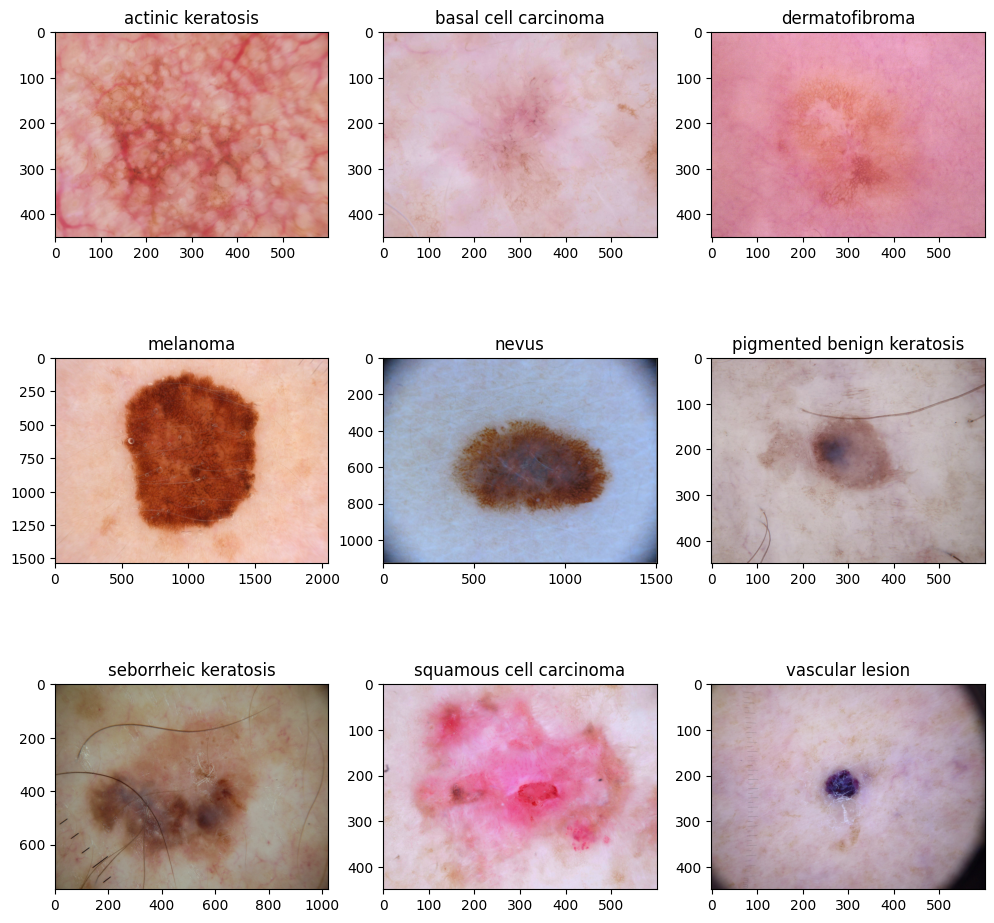

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here
num_class = len(class_names)
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding='same', input_shape= (img_height, img_width, batch_size)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class))
model.add(Activation("softmax"))


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function
#opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.experimental.SGD(learning_rate=0.01),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 779s 3s/step - loss: 4.2469 - accuracy: 0.2059 - val_loss: 5.0952 - val_accuracy: 0.1521
Epoch 2/20
56/56 [==============================] - 8s 137ms/step - loss: 2.0173 - accuracy: 0.2734 - val_loss: 6.9199 - val_accuracy: 0.0872
Epoch 3/20
56/56 [==============================] - 8s 143ms/step - loss: 1.9470 - accuracy: 0.3069 - val_loss: 6.9564 - val_accuracy: 0.1051
Epoch 4/20
56/56 [==============================] - 8s 138ms/step - loss: 1.8632 - accuracy: 0.3365 - val_loss: 5.8272 - val_accuracy: 0.1924
Epoch 5/20
56/56 [==============================] - 8s 139ms/step - loss: 1.8431 - accuracy: 0.3571 - val_loss: 3.0513 - val_accuracy: 0.2774
Epoch 6/20
56/56 [==============================] - 8s 138ms/step - loss: 1.7520 - accuracy: 0.3616 - val_loss: 3.1625 - val_accuracy: 0.3579
Epoch 7/20
56/56 [==============================] - 8s 139ms/step - loss: 1.7087 - accuracy: 0.3778 - val_loss: 5.8304 - val_accuracy: 0.2103
Epoch 8

### Visualizing training results

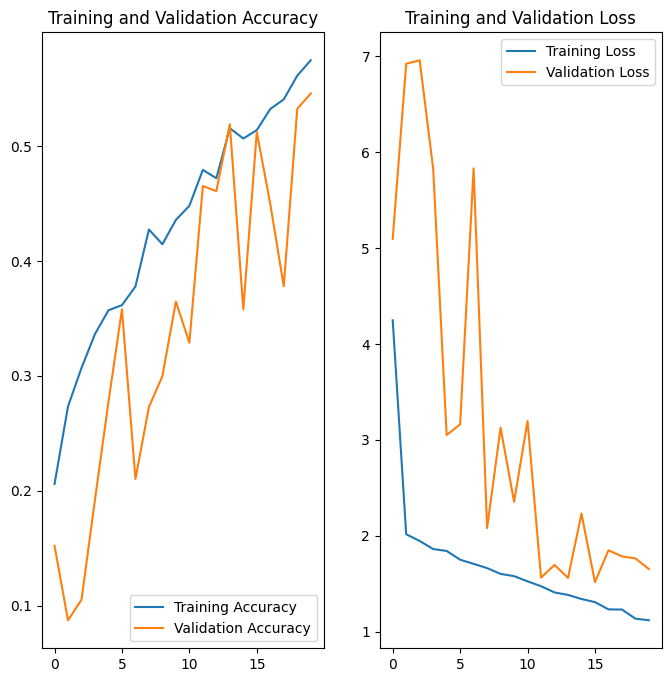

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
**Training and Validation accuracy does not have much of difference. But Training accuracy on the data is very less. So the model is Underfitting**

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augment = Sequential([
    layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(factor = 0.2),
    #layers.experimental.preprocessing.RandomTranslation(0.2,0.2),
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
    #layers.experimental.preprocessing.RandomCrop(240,240),
    #layers.experimental.preprocessing.RandomContrast(0.2)
])

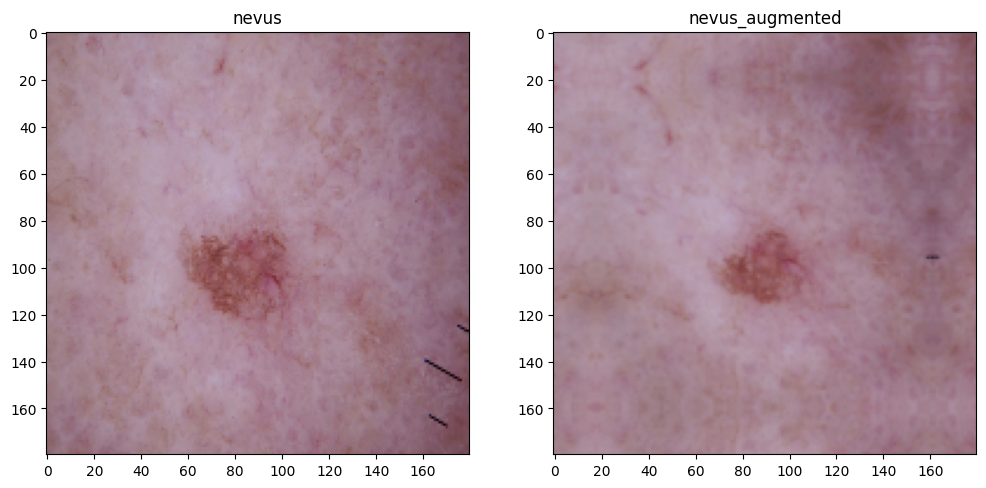

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    img = images[0]
    aug_img = data_augment(images[0])
    label = class_names[labels[0]]
plt.subplot(1,2,1)
plt.imshow(img.numpy().astype('uint8'))
plt.title(label)
plt.subplot(1,2,2)
plt.imshow(aug_img.numpy().astype('uint8'))
plt.title('{}_augmented'.format(label))
plt.show()

### Todo:
### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
num_class = len(class_names)
model2 = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    data_augment
])
model2.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding='same', input_shape= (img_height, img_width, batch_size)))
model2.add(BatchNormalization())
model2.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding='same'))
model2.add(BatchNormalization())
model2.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_class))
model2.add(Activation("softmax"))


### Compiling the model

In [21]:
## Your code goes here
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.experimental.SGD(learning_rate=0.01),
              metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (180, 180, 3)             0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_5 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                      

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 10s 146ms/step - loss: 3.7265 - accuracy: 0.2026 - val_loss: 3.7947 - val_accuracy: 0.1521
Epoch 2/20
56/56 [==============================] - 8s 140ms/step - loss: 2.1213 - accuracy: 0.2478 - val_loss: 4.7676 - val_accuracy: 0.0738
Epoch 3/20
56/56 [==============================] - 8s 148ms/step - loss: 1.9824 - accuracy: 0.2868 - val_loss: 5.4275 - val_accuracy: 0.1477
Epoch 4/20
56/56 [==============================] - 8s 148ms/step - loss: 1.9814 - accuracy: 0.2980 - val_loss: 4.8320 - val_accuracy: 0.1745
Epoch 5/20
56/56 [==============================] - 8s 142ms/step - loss: 1.9062 - accuracy: 0.3013 - val_loss: 3.7180 - val_accuracy: 0.2282
Epoch 6/20
56/56 [==============================] - 8s 142ms/step - loss: 1.8504 - accuracy: 0.3147 - val_loss: 2.3775 - val_accuracy: 0.2595
Epoch 7/20
56/56 [==============================] - 8s 148ms/step - loss: 1.8451 - accuracy: 0.3186 - val_loss: 1.9023 - val_accuracy: 0.3110
Epoch

### Visualizing the results

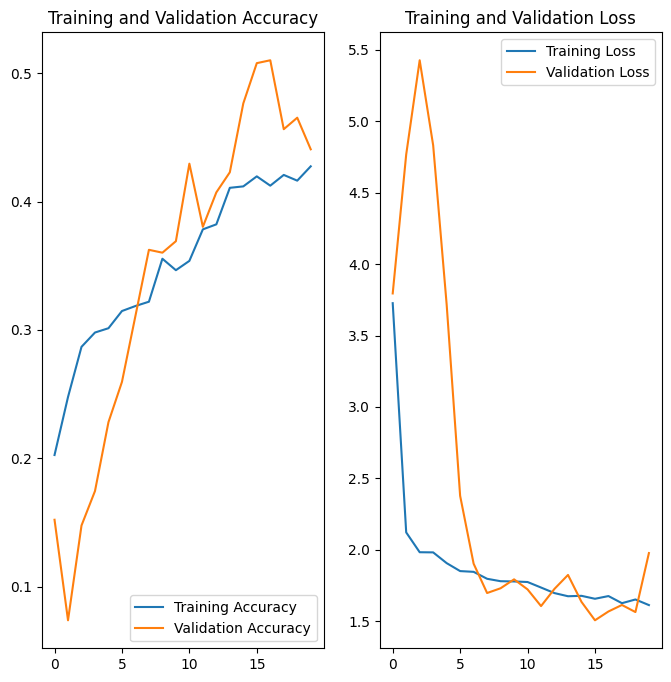

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Finding - Test accuracy is still low. So the Model still Underfit**

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*/*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*/*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()), columns = ['Path','Label'])
cnt_df = original_df['Label'].value_counts().reset_index()
cnt_df

,index,Label
0,pigmented benign keratosis,462
1,melanoma,438
2,basal cell carcinoma,376
3,nevus,357
4,squamous cell carcinoma,181
5,vascular lesion,139
6,actinic keratosis,114
7,dermatofibroma,95
8,seborrheic keratosis,77


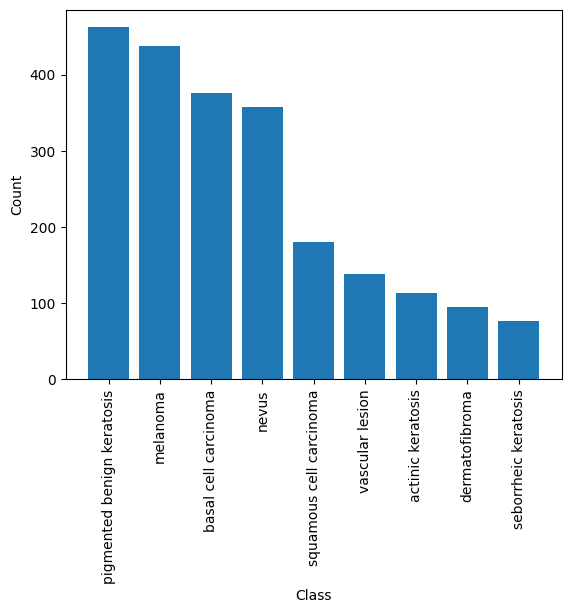

In [25]:
plt.bar(cnt_df['index'], cnt_df['Label'])
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [26]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

1. **seborrheic keratosis has least number of samples**
2. **pigmented benign keratosis, melanoma, basal cell carcinoma, nevus dominate the data in terms proportionate number of samples**

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [37]:
path_to_training_dataset="/content/gdrive/MyDrive/melanoma_detection_assignment/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma_detection_assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC8104A26B0>: 100%|██████████| 500/500 [00:22<00:00, 22.46 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma_detection_assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC810381BA0>: 100%|██████████| 500/500 [00:21<00:00, 23.22 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma_detection_assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC836453A90>: 100%|██████████| 500/500 [00:23<00:00, 21.22 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma_detection_assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC810176DD0>: 100%|██████████| 500/500 [01:40<00:00,  5.00 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma_detection_assignment/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7FC7A016FB50>: 100%|██████████| 500/500 [01:55<00:00,  4.33 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma_detection_assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC816499120>: 100%|██████████| 500/500 [00:22<00:00, 22.13 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma_detection_assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC83628CA30>: 100%|██████████| 500/500 [00:49<00:00, 10.15 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma_detection_assignment/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC836453A90>: 100%|██████████| 500/500 [00:20<00:00, 24.47 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/melanoma_detection_assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC8341CF910>: 100%|██████████| 500/500 [00:23<00:00, 21.58 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [43]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [44]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/melanoma_detection_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026650.jpg_d1199f34-72be-41ed-8bb1-a0d38ba86700.jpg',
 '/content/gdrive/MyDrive/melanoma_detection_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029827.jpg_7c8bd714-e145-42ab-8e2b-c987c35bdbb4.jpg',
 '/content/gdrive/MyDrive/melanoma_detection_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029713.jpg_5512a3ab-1fec-4f7e-b827-eee22e52cba5.jpg',
 '/content/gdrive/MyDrive/melanoma_detection_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026905.jpg_1432ca08-f3d5-43eb-b786-38f97330f941.jpg',
 '/content/gdrive/MyDrive/melanoma_detection_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027562.jpg_93aa88e8-9568-470d-92a3-e46e6735f0e2.jpg',
 '/content/gdrive/MyDrive/melanoma_detection_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026702.jpg

In [45]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [46]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [47]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], axis=0)

In [48]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [49]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [50]:
data_dir_train="/content/gdrive/MyDrive/melanoma_detection_assignment/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [51]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [52]:
## your code goes here
num_class = len(class_names)
model3 = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model3.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding='same', input_shape= (img_height, img_width, batch_size)))
model3.add(BatchNormalization())
model3.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2)))
model3.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2,2)))
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(128))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(num_class))
model3.add(Activation("softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [53]:
## your code goes here
model3.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.experimental.SGD(learning_rate=0.01),
              metrics=['accuracy'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_9 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)      

#### **Todo:**  Train your model

In [54]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 45s 254ms/step - loss: 2.8868 - accuracy: 0.1838 - val_loss: 5.4312 - val_accuracy: 0.1492
Epoch 2/30
169/169 [==============================] - 46s 261ms/step - loss: 2.0384 - accuracy: 0.2205 - val_loss: 2.4227 - val_accuracy: 0.1321
Epoch 3/30
169/169 [==============================] - 42s 244ms/step - loss: 1.9081 - accuracy: 0.2570 - val_loss: 1.7084 - val_accuracy: 0.3252
Epoch 4/30
169/169 [==============================] - 42s 243ms/step - loss: 1.8029 - accuracy: 0.2932 - val_loss: 6.6922 - val_accuracy: 0.1529
Epoch 5/30
169/169 [==============================] - 44s 254ms/step - loss: 1.7224 - accuracy: 0.3194 - val_loss: 1.7380 - val_accuracy: 0.3096
Epoch 6/30
169/169 [==============================] - 43s 247ms/step - loss: 1.6115 - accuracy: 0.3624 - val_loss: 2.1311 - val_accuracy: 0.3452
Epoch 7/30
169/169 [==============================] - 42s 245ms/step - loss: 1.5466 - accuracy: 0.3950 - val_loss: 1.5871 - val_ac

#### **Todo:**  Visualize the model results

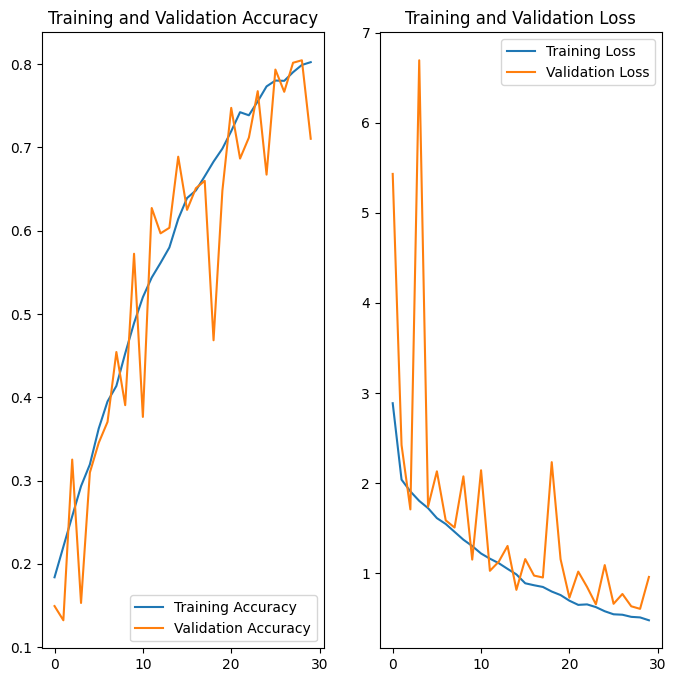

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**The model accuracy after 30 epoch on training is aroung 80 and for val it is 71. So the model does not look to overfit. Also the accuracy have improved which resolved the underfitting issue. So, Yes, class rebalance helped to improve the model.**